In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm
import subprocess

In [2]:
## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso1 = "Mg"
iso2 = "P" 
iso3 = "Al"
iso4 = "Si"
_path1 = datapath + "bananas/" + iso1
_path2 = datapath + "bananas/" + iso2
_path3 = datapath + "bananas/" + iso3
_path4 = datapath + "bananas/" + iso4

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files1 = glob.glob(os.path.join(_path1, "*mlio.root"))
_files2 = glob.glob(os.path.join(_path2, "*mlio.root"))
_files3 = glob.glob(os.path.join(_path3, "*mlio.root"))
_files4 = glob.glob(os.path.join(_path4, "*mlio.root"))


In [10]:
#### Loading in of the data files storing them in a dictionary
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso4: _files4,
    
}
data_collection = {
    iso1 : {},

}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for i in range(6)} for isotope in data_files}

for isotope, files in data_files.items():
    #file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), dynamic_ncols=True)
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(6):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si:   0%|           0/11 [00:00<?, ?file/s]

Processing Si: 100%|██████████ 11/11 [00:42<00:00,  3.82s/file]


In [4]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

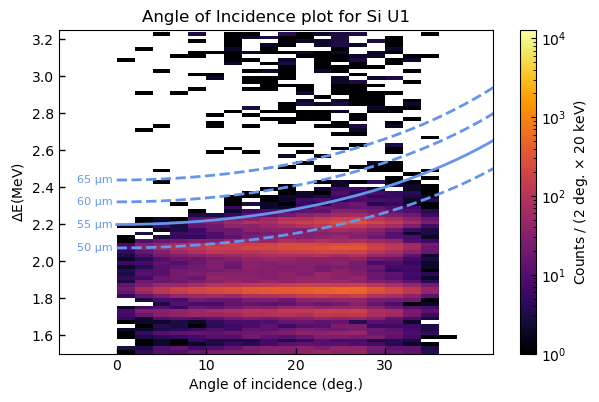

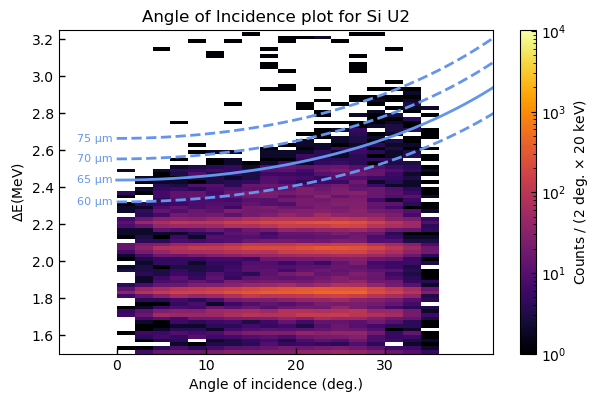

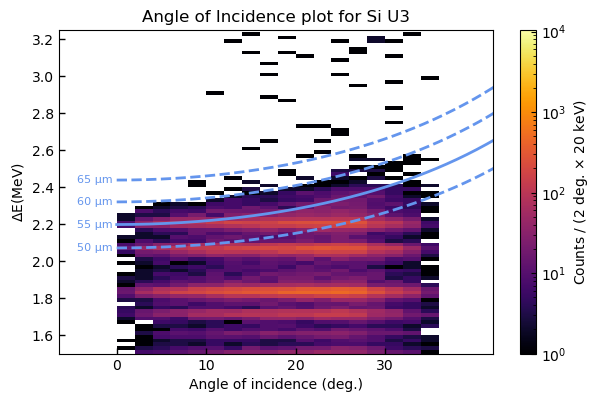

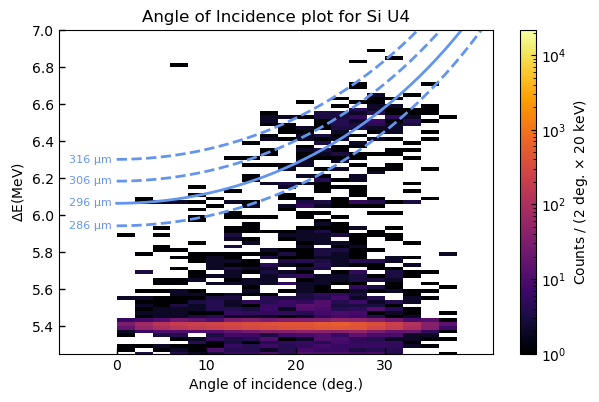

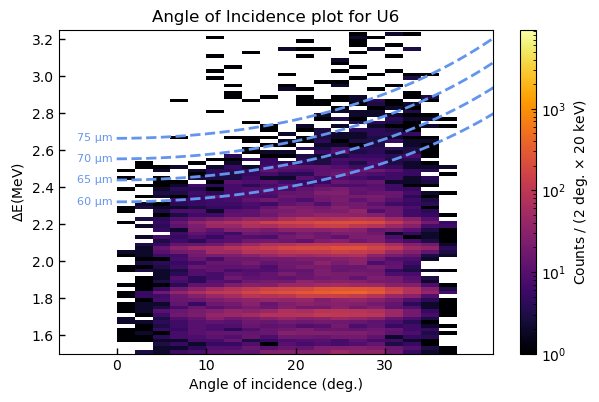

In [16]:
def eloss(v, a, b):
    return a*(1 + b*(1 - np.cos(v))/np.cos(v))

V = np.linspace(0, np.pi/4, 200)

linecol = 'cornflowerblue'
isos = [iso4]
implantation = ["17"]
dets = ["U1", "U2", "U3", "U4", "U6"]
pads = ["P1", "P2", "P3", "P4", "P6"]
t_low = [50., 60., 50., 286., 60.]
t_up = [65., 75., 65., 316., 75.]
t_step = [5., 5., 5., 10., 5.]
t_stated = [55., 65., 55., 296., 67.]
ylim_max = [3.25,3.25,3.25,7., 3.25]
ylim_low = [1.5, 1.5, 1.5, 5.25, 1.5]
for iso, imp in zip(isos,implantation):

    for i in range(0,5):
        if i==4:
            det = f"id{i+1}"
        else:
            det = f"id{i}"
        plt.figure(figsize=(7,4.2))
        a = data_collection[iso][det]["angle"]
        e = data_collection[iso][det]["Edep"]
        simdir = "/home/haue/repositories/Masters/simdata/"
        curdir = os.getcwd()
        os.chdir(simdir)
        ps = []
        ts = []
        for t in np.arange(t_low[i], t_up[i]+t_step[i], t_step[i]):
            filename = "%stdz_21_%d.dat" % (iso+dets[i], int(t))
            if not os.path.exists(filename):
                f = open(filename, "w")
                subprocess.call(["TDZ", "-d%s,%s" % (dets[i], pads[i]), f"-i{imp}", "--ft=%s" % str(t)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
                f.close()
            sim_ang, sim_fedepup, sim_Elow, sim_Eup, sim_fedeplow, sim_Eplow = np.loadtxt(filename, unpack=True)
            res = sc.curve_fit(eloss, sim_ang, sim_fedepup, p0=(np.min(sim_fedepup), 1.))
            ps.append(res[0])
            ts.append(t)
        os.chdir(curdir) 
    
        plt.hist2d(a, e, bins=(np.arange(0, 42, 2), np.arange(0, ylim_max[i], 0.02)), 
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm())
        cbar = plt.colorbar()
        cbar.set_label('Counts / (2 deg. $\\times$ 20 keV)')
    
        for p,t in zip(ps,ts):
            if int(t) == t_stated[i]:
                plt.plot(np.rad2deg(V), eloss(V, *p)/1e3, color=linecol, ls='-', lw=2)
                plt.text(-0.5, np.min(eloss(V, *p))/1e3, "%d µm" % int(t), color=linecol, fontsize=8, ha='right', va='center')
            else:
                plt.plot(np.rad2deg(V), eloss(V, *p)/1e3, color=linecol, ls='--', lw=2)
                plt.text(-0.5, np.min(eloss(V, *p))/1e3, "%d µm" % int(t), color=linecol, fontsize=8, ha='right', va='center')

    
    
    
    
    
    ##Formatting of figures
        plt.xticks(np.arange(0, 40, 10))
        plt.xlim(-6.5, 42)
        plt.tick_params(axis='y', which='major', direction='in', length=4, width=1)
        plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
        plt.tick_params(axis='x', which='major', direction='in', length=4, width=1)
    #plt.gca().set_yticks(np.arange(0, 7.5, 0.5), minor=True)
        plt.xlabel("Angle of incidence (deg.)")
        plt.ylabel("$\Delta$E(MeV)")
        if i==4:
            plt.title(f"Angle of Incidence plot for U{i+2}", fontsize=12)

        else:
            plt.title(f"Angle of Incidence plot for {iso} U{i+1}", fontsize=12)

        plt.ylim(ylim_low[i], ylim_max[i])